In [2]:
import os
import imageio
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import qutip
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter, LinearLocator
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import scipy

**Note:** Some parts of code were taken from chatgpt.

In [18]:
def animate_bloch(states, eig_states, name, duration=0.1, save_all=False):

    b = qutip.Bloch()
    b.vector_color = ["r"]
    # b.view = [-40,30]
    images = []

    try:
        length = len(states)
    except:
        length = 1
        states = [states]
    ## normalize colors to the length of data ##
    # nrm = mpl.colors.Normalize(0,length)
    # colors = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    # b.point_color = [colors[0]] # options: 'r', 'g', 'b' etc.
    b.point_marker = ["o"]
    b.point_size = [25]

    for i in range(length):
        b.clear()
        b.add_states(eig_states)
        b.add_states(states[i])
        b.add_states(states[: (i + 1)], "point")
        if save_all:
            b.save(dirc="sphere")  # saving images to tmp directory
            filename = "sphere/bloch_%01d.png" % i
        else:
            filename = "temp_file.png"
            b.save(filename)
        images.append(imageio.v2.imread(filename))
    imageio.mimsave(f"{name}.gif", images, duration=duration)

### Exercise 12

Verify all the other commutation relations involving Pauli matrices by directly multiplying the corresponding matrices. Feel free to do it on a computer.

In [3]:
x = qutip.sigmax().full()
y = qutip.sigmay().full()
z = qutip.sigmaz().full()

In [4]:
def commutation(a, b):
    return qutip.Qobj(a @ b - b @ a)

In [5]:
commutation(x, y)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.+2.j 0.+0.j]
 [0.+0.j 0.-2.j]]

In [6]:
commutation(z, x)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.  2.]
 [-2.  0.]]

In [7]:
commutation(y, z)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=False
Qobj data =
[[0.+0.j 0.+2.j]
 [0.+2.j 0.+0.j]]

In [8]:
commutation(x, x)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 0.]]

In [9]:
commutation(y, y)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 0.]]

In [10]:
commutation(z, z)

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0.]
 [0. 0.]]

### Exercise 14

Continuing from the previous exercise, note that the Eq. 8 for the evolution of $x(t)$ and $y(t)$ is exactly the same as the equation of motion for the harmonic oscillator. Show the time-evolution in the $x$-$y$ plane (equatorial plane of the Bloch sphere).



In [11]:
# Define constants
omega_Z = 1.0  # Frequency for Z-axis rotation
tlist = np.linspace(0, 10, 500)  # Time array

# Pauli matrices
sx = qutip.sigmax()
sy = qutip.sigmay()
sz = qutip.sigmaz()

# Define the initial state in the x-y plane (e.g., |+> state, which lies in x-axis)
psi0 = (qutip.basis(2, 0) + qutip.basis(2, 1)).unit()  # This is the |+> state

# Define the Hamiltonian for rotation around Z-axis
H = -0.5 * omega_Z * sz

In [12]:
# Solve the time evolution
result = qutip.mesolve(H, psi0, tlist, [], [sx, sy, sz])

# Extract expectation values of X, Y, and Z
x_expect = result.expect[0]
y_expect = result.expect[1]
z_expect = result.expect[2]

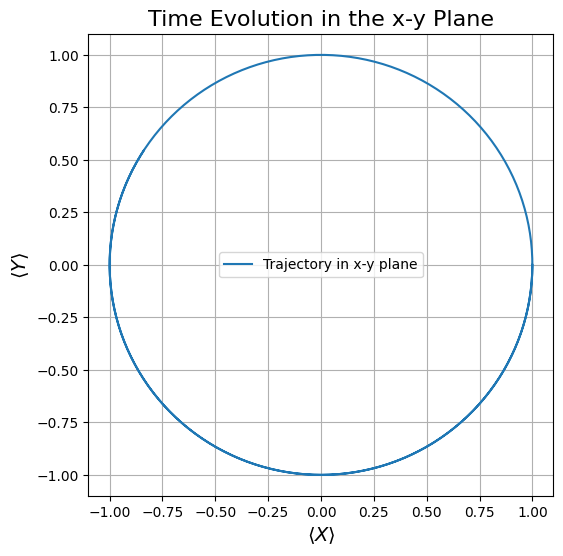

In [13]:
# Plot the evolution of X and Y (x-y plane)
plt.figure(figsize=(6, 6))
plt.plot(x_expect, y_expect, label='Trajectory in x-y plane')
plt.xlabel(r'$\langle X \rangle$', fontsize=14)
plt.ylabel(r'$\langle Y \rangle$', fontsize=14)
plt.title("Time Evolution in the x-y Plane", fontsize=16)
plt.grid()
plt.legend()
plt.show()

### Exercise 15

Set $\omega_X = \omega_Y = \omega_Z = 1$ and solve the equation of motion for $x, y, z$ numerically using any solver you have available. You basically need to exponentiate the matrix $\hat{M}$. Demonstrate that the solution is a rotation of the initial $(x, y, z)$-vector around the vector oriented along $(1, 1, 1)$.

In [14]:
def bloch_vector_to_statevector(bloch_vector):
    # Unpack the Bloch vector
    x, y, z = bloch_vector
    
    # Calculate the norm of the Bloch vector
    r = np.sqrt(x**2 + y**2 + z**2)
    
    # Normalize the vector (if r is zero, return the ground state |0⟩)
    if r == 0:
        return qutip.basis(2, 0)  # The |0⟩ state
    
    # Normalize the Bloch vector
    x_norm = x / r
    y_norm = y / r
    z_norm = z / r

    # Calculate theta and phi
    theta = np.arccos(z_norm)  # Angle from z-axis
    phi = np.arctan2(y_norm, x_norm)  # Angle in x-y plane

    # Convert to the quantum state |ψ⟩
    statevector = (np.cos(theta / 2) * qutip.basis(2, 0) + 
                   np.exp(1j * phi) * np.sin(theta / 2) * qutip.basis(2, 1))
    
    return statevector

In [15]:
# Define constants
omega_X = 1.0
omega_Y = 1.0
omega_Z = 1.0

# Define the matrix M
M = np.array([[0, -omega_Z, omega_Y],
              [omega_Z, 0, -omega_X],
              [-omega_Y, omega_X, 0]])

# Define time parameters
tlist = np.linspace(0, 10, 50)  # Time array
initial_vector = np.array([1, 0, 0])  # Initial state vector (along x-axis)

# Prepare to store results
trajectory = np.zeros((len(tlist), 3))

# Calculate the trajectory using matrix exponentiation
for i, t in enumerate(tlist):
    # Calculate the matrix exponential
    exp_M_t = scipy.linalg.expm(M * t)
    # Calculate the new state vector
    trajectory[i] = exp_M_t @ initial_vector

# Extract x, y, and z components
x_values = trajectory[:, 0]
y_values = trajectory[:, 1]
z_values = trajectory[:, 2]

In [16]:
svs = [bloch_vector_to_statevector([i[0], i[1], i[2]]) for i in trajectory]

In [19]:
animate_bloch(svs, bloch_vector_to_statevector([1, 1, 1]), "ex_15")

The animated bloch sphere is shown below. The solution is a rotation of the initial $(x, y, z)$-vector around the vector oriented along $(1, 1, 1)$.

<div align="center">
<img width="400" src="ex_15.gif" /><br>
</div>

We can check that all the vectors have same angle with the vector $(1, 1, 1)$

In [20]:
axis_vec = np.array([1., 1, 1])
axis_vec /= np.linalg.norm(axis_vec)

vec = trajectory[0]
angle = np.arccos(np.dot(axis_vec, vec))

print('angle:', angle)

for vec in trajectory[1:]:
    assert np.allclose(np.arccos(np.dot(axis_vec, vec)), angle) == True

angle: 0.9553166181245091
